## CloudDBH

Running on data from Calders et al.

In [1]:
import numpy as np
import pandas as pd
import glob
import sys
import os
import gc
import open3d as o3d

from shapely.ops import cascaded_union, polygonize
from shapely.geometry import Polygon, LineString
import shapely.geometry as geometry

from scipy import optimize
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay
import scipy.io as sio

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import math
from math import pi

from sklearn.neighbors import NearestNeighbors
from descartes import PolygonPatch


# Functions

In [2]:
# Functions from Calders et al
# nearest neighbour needed for outlier removal
def nn(x,rad):
    """
    Function from TLS_Inventory.
    
    x: a numpy array, rad: radius to search for neighbors within
    
    My understanding - can either specify number of neighbors to return (in sklearn NearestNeighbors),
    or return all the neighbors and then filter to return only those within a specified distance radius
    """
    nbrs = NearestNeighbors(algorithm='auto', metric='euclidean').fit(x) 
    distances, indices = nbrs.radius_neighbors(radius=rad) #find all neighbours within this search radius
    
    #output explained: https://stackoverflow.com/questions/53886289/confused-with-the-output-of-sklearn-neighbors-nearestneighbors 
    return distances, indices


def load_pts(cloud,downsample=False,outliers=False): 
    """
    Function from TLS_Inventory that reads the point cloud data for single tree at a time and
    returns pandas dataframe with the points split into x, y, z coordinates. 
    
    cloud: point cloud from a single tree - note, point cloud data should be pre-processed and 
           split into individual trees prior to using this function.
    downsample (Optional): Default is False, meaning all the points are retained. If 
                           True, the point clouds are sampled to keep only fraction of points.
    outliers (Optional): Default is False, meaning outliers are retained. If True, 
    """
    # read the point cloud data for single tree and save as pandas df with columns for x, y, z coords
    dftemp=o3d.io.read_point_cloud(cloud)
    df=pd.DataFrame(data=np.asarray(dftemp.points),columns=['x', 'y', 'z']) #access the points
    
    # Optional downsampling
    if downsample:
        df=df.sample(frac=0.1) # keep 10pct of points
    
    # Optional outlier removal 
    if outliers: #remove outliers
        xy=df.iloc[:,0:2].values # takes ALL rows, first and second column - x and y - and .values converts to numpy array
        dist, indi = nn(xy,0.5) # get nearest neighbors within search radius of 0.5
        cnt=[len(i) for i in indi] # count the kNN within the search radius
        cnt = pd.DataFrame({'count':cnt})
        
        # set threshold for the number of neighbors we want to keep 
        threshold=df.shape[0]*0.0001 #1 neighbor for every 10 000 pts
        
        removed=sum(np.array(cnt)<threshold)
        df=df[np.array(cnt)>=threshold]
        print("Removed %i outliers using kNN threshold %.2f" % (removed[0], threshold-1))
    
    return df #return pandas dataframe 

In [3]:
# TODO: error checking - length of tree list to plot etc, dynamic fig size
def formatplots(trees, ncols=4, shape='square'):
    # determine number of subplots
    nplots = len(trees)
    
    # determine number of rows 
    if(nplots % ncols) != 0:
        nrows = int(nplots / ncols + 1)
    else:
        nrows = int(nplots / ncols)

    if shape == 'horiz':
        # initiate figure with nrows and ncols
        fig, axs = plt.subplots(nrows, ncols, figsize=(20,nrows*4))
        fig.tight_layout()
    if shape == 'vert':
        # initiate figure with nrows and ncols
        fig, axs = plt.subplots(nrows, ncols, figsize=(20,nrows*10))
        fig.tight_layout()
    if shape == 'square':
        # initiate figure with nrows and ncols
        fig, axs = plt.subplots(nrows, ncols, figsize=(20,nrows*10))
        fig.tight_layout()
    
    return fig, axs

In [4]:
def construct_treeid(tree, ptspath):
    if tree[-4:] != '.ply':
        tree = str(ptspath) + '/wytham_winter_' + str(tree) + '.ply' # TODO: don't hard code this
    else:
        tree = tree # TODO: make this more robust
        
    tree_num = tree.split("_")[-1].split(".")[0]
    
    return tree, tree_num

In [5]:
def update_inds(treeind, rowind, colind, ncols):
    # increase tree index to get to next tree
    treeind += 1

    if (treeind % ncols) != 0:
        colind += 1
    else:
        rowind +=1 
        colind = 0
    
    return treeind, colind, rowind

In [6]:
def split_singlemulti(ptspath):

    singlestemmed = []
    multistemmed = []
    
    # get list of trees from pts path
    trees = glob.glob("%s/*ply" % pts_path)
    
    for tree in trees:
        tree_num = tree.split("_")[-1].split(".")[0]
        
        # if the treeID ends in a letter, it is not single stem
        if tree_num[-1].isalpha():
            multistemmed.append(tree)
        else:
            singlestemmed.append(tree)

    return singlestemmed, multistemmed

In [7]:
def calc_convexhull(tree, ptspath, hgt=1.3):
    """
    Function to calculate and plot convex hulls for each tree in a list of trees.
    """

    # Get treeID
    tree, tree_num = construct_treeid(tree, ptspath)

    #get DBH from full cloud to preserve max number of hits on stem slice
    pts = load_pts(tree,False,False)

    # extract part of df with z values between 1.27 and 1.33 m by default - Tansey et al. 2009, Calders et al. 2015
    pts_dbh = pts[(pts['z'] > pts['z'].min() + hgt - 0.03) & (pts['z'] < pts['z'].min() + hgt + 0.03)]
    xy_dbh_arr = np.asarray(pts_dbh[['x', 'y']])

    # Calculate DBH (convex hull) using scipy ConvexHull
    dbh = ConvexHull(xy_dbh_arr)
    
    #df_dbh = pd.DataFrame({'TLS_ID': [tree_num], 'DBH_CV': [dbh.area], 'DBH_Verts': [len(dbh.vertices)]})
                          
    return dbh.area, len(dbh.vertices), pts_dbh, dbh
    

In [8]:
def plot_convexhull(treelist, ptspath, ncols=4, fixedheight = True, hgt=1.3, hgtlist = None):
    fig, axs = formatplots(treelist, ncols)
    rowind = colind = treeind = 0
    
    for tree in treelist:
        tree, tree_num = construct_treeid(tree, ptspath)
        
        if fixedheight:
            hgt = hgt
        else:
            hgt = hgtlist[tree_num]
        
        dbh_cv, verts, pts_dbh, dbh = calc_convexhull(tree, pts_path, hgt=hgt)
        xy_dbh_arr = np.asarray(pts_dbh[['x', 'y']])
        
        
        axs[rowind, colind].scatter(pts_dbh['x'], pts_dbh['y']) 
        
        # plot line connecting all the dbh vertices
        for simplex in dbh.simplices:
            axs[rowind, colind].plot(xy_dbh_arr[simplex, 0], xy_dbh_arr[simplex, 1], 'r--')
        
        axs[rowind, colind].plot(xy_dbh_arr[dbh.vertices,0], xy_dbh_arr[dbh.vertices,1], 'r--', label=f"DBH: {dbh.area:.3f}") # DBH (convex hull)
        axs[rowind, colind].plot(xy_dbh_arr[dbh.vertices,0], xy_dbh_arr[dbh.vertices,1], 'ro', label=f"Vertices: {len(dbh.vertices)}") # vertices

        axs[rowind, colind].set_title(f'DBH (Convex Hull) for {tree_num}')
        axs[rowind, colind].legend(fontsize='xx-large', loc='upper left')
        axs[rowind, colind].axis('equal')

        treeind, colind, rowind = update_inds(treeind, rowind, colind, ncols)
    return

In [9]:
def iter_dbh(tree, ptspath, step=0.1, lim=3):
    """
    Start from bottom of tree and calculate convex hull in 0.06m slices separated
    by defined step size until 3m. 
    """

    # Get treeID
    tree, tree_num = construct_treeid(tree, ptspath)

    #get DBH from full cloud to preserve max number of hits on stem slice
    pts = load_pts(tree,False,False)

    # calculate dbh for slices up to smaller of lim or tree height
    disc = 0.1
    hgt = pts['z'].max() - pts['z'].min()
    
    # initialize empty lists to hold values for each tree
    dbh_list = []
    vert_list = []
    disc_list = []
    flag_list = []

    # loop upward through height of tree (up to lim)
    while disc < lim and disc < hgt:
        # Calculate DBH (convex hull) for current slice using scipy ConvexHull
        pts_slice = pts[(pts['z'] > pts['z'].min() + disc - 0.03) & (pts['z'] < pts['z'].min() + disc + 0.03)]
        xy_dbh = np.asarray(pts_slice[['x', 'y']])

        if len(xy_dbh) < 3:
            print(f'tree {tree_num} had not enough points at disc {disc}')
            disc += step
            break

        dbh = ConvexHull(xy_dbh)

        if len(dbh_list) > 1:
            if dbh.area > min(dbh_list) + min(dbh_list)*0.5:
                flag_list.append(1)
            else:
                flag_list.append(0)
        else:
            flag_list.append(0)

        # append data to lists
        dbh_list.append(dbh.area)
        vert_list.append(len(dbh.vertices))
        disc_list.append(disc)


        # move up to next slice  
        disc += step
    
    df_out = pd.DataFrame(list(zip(dbh_list, vert_list, disc_list, flag_list)), columns = ['DBH_CV', 'DBH_Verts', 'Slice_Hgt', 'Flagged'])
    return tree_num, df_out
            

In [10]:
def plot_iter_dbh(iterdbh_dict, ncols = 2):
    """
    Takes the output of function iter_dbh and plots results in grid.
    """
    
    # sort output of iter_dbh function and get list of unique trees
    #iterdbhout.sort_values('TLS_ID', inplace=True)
    #uniquetrees = iterdbhout.TLS_ID.unique()
    
    uniquetrees = iterdbh_dict.keys()
    
    # format plotting grid
    fig, axs = formatplots(uniquetrees, ncols, shape='horiz')
    rowind = colind = treeind = 0

    # initiate figure with nrows and ncols
    #fig, axs = plt.subplots(nrows, ncols, figsize=(40,180), sharex=True)
    axs[0, 0].set_xlim(right=3)

    for tree in uniquetrees:
        #treedf = iterdbhout.loc[iterdbhout['TLS_ID'] == tree]
        treedf = iterdbh_dict[tree]
        filt = treedf['Flagged'] == 1

        # calculate trendline on valid data
        # validdf = treedf[~filt]
        
        # plot data
        axs[rowind, colind].scatter(treedf['Slice_Hgt'], treedf['DBH_CV'])
        axs[rowind, colind].set_title(f'DBH w Height for {tree}', fontsize=20)
        axs[rowind, colind].set_xlabel('Height of DBH Slice (m)', fontsize=20)
        axs[rowind, colind].set_ylabel('Value of DBH Slice (m)', fontsize=20)
        axs[rowind, colind].plot(treedf['Slice_Hgt'][filt], treedf['DBH_CV'][filt],'r+', markersize=20)
        fig.tight_layout()

        
        treeind, colind, rowind = update_inds(treeind, rowind, colind, ncols)
    
    return

In [11]:
def get_dbh_hgt(iterdbh_dict):
    """
    Take output of iter_dbh function and determine ideal height from which to calculate dbh
    """
    trees = iterdbh_dict.keys()

    dbh_hgts = {}
    for tree in trees:
        treedf = iterdbh_dict[tree]
        
        filt = treedf['Flagged'] == 1

        # select only non-flagged data
        validdf = treedf[~filt]

        disclist = list(validdf['Slice_Hgt'])
        
        dif = lambda disclist : abs(disclist - 1.3)
 
        res = min(disclist, key=dif)

        print(f'tree {tree}, res: {res}')
        
        dbh_hgts[tree] = res
        
    return dbh_hgts


In [12]:
def plot2D(trees, ptspath, ncols=4, dbh=True, iterdbh=False, hgtlist = None):
    """
    Function to plot tree point clouds in x/z or y/z direction
    
    TODO: make iter dbh function work on just one tree - then call iter_dbh from within this function
    """
    # determine number of rows to plot figures
    fig, axs = formatplots(trees, ncols)
    rowind = colind = treeind = 0

    # loop through trees
    for tree in trees:
        # Get treeID
        tree, tree_num = construct_treeid(tree, ptspath)

        #get DBH from full cloud to preserve max number of hits on stem slice
        pts = load_pts(tree,False,False)

        # calculate tree height
        tree_hgt = pts['z'].max() - pts['z'].min()
            
        max_pt = pts[pts['z'] == pts['z'].max()]

        # plot scatter plot of points in x and z 
        axs[rowind, colind].scatter(pts['x'], pts['z'], s=3) 
        if dbh: 
            pts_dbh = pts[(pts['z'] > pts['z'].min() + 1.27) & (pts['z'] < pts['z'].min() + 1.33)]
            axs[rowind, colind].plot(pts_dbh['x'], pts_dbh['z'], 'ro', markersize=3, label=f"DBH Slice")
        
        if iterdbh: 
            hgt = hgtlist[tree_num]
            pts_hgt = pts[(pts['z'] > pts['z'].min() + hgt - 0.03) & (pts['z'] < pts['z'].min() + hgt + 0.03)]
            axs[rowind, colind].plot(pts_hgt['x'], pts_hgt['z'], 'yo', markersize=3, label=f"HGT Slice")
            

        axs[rowind, colind].annotate(f'Height: {tree_hgt:.2f}', xy=(max_pt['x'], max_pt['z']), va='top', ha='left', size=15)
        axs[rowind, colind].legend(fontsize='xx-large', loc='upper left')
        axs[rowind, colind].set_title(f'{tree_num} ({rowind}, {colind})')

        # increase tree index to get to next tree
        treeind, colind, rowind = update_inds(treeind, rowind, colind, ncols)
    return



# Main Code

In [13]:
pts_path = "/Users/snix/Documents/2021-2023/UCL/Dissertation/DATA_clouds_ply"
qsm_path = "/Users/snix/Documents/2021-2023/UCL/Dissertation/DATA_QSM_opt/"
tree_csv_path = "/Users/snix/Documents/2021-2023/UCL/Dissertation/Calders Et Al/analysis_and_figures/trees_summary.csv"


In [14]:
trees = glob.glob("%s/*ply" % pts_path)
singlestemmed, multistemmed = split_singlemulti(pts_path)

print(f'Singlestemmed: {len(singlestemmed)}')
print(f'Multistemmed: {len(multistemmed)}')

Singlestemmed: 585
Multistemmed: 291


### Calculate Convex Hull at 1.3:

In [15]:
datadict = {}

for tree in singlestemmed:
    # construct tree id
    tree, tree_num = construct_treeid(tree, pts_path)
    
    # calc convex hull
    dbh_cv, verts, pts_dbh, dbh = calc_convexhull(tree, pts_path, hgt=1.3)
    
    datadict[tree_num] = {'dbh_cv': dbh_cv, 'verts': verts}

In [16]:
plot_convexhull(singlestemmed[0:8], pts_path, ncols=4, fixedheight = True)

In [17]:
datadf = pd.DataFrame.from_dict(datadict, orient='index')

datadf = datadf.reset_index()
datadf = datadf.rename(columns={"index": "TLS_ID"})


datadf.head()

TLS_ID    dbh_cv  verts
0   1623  0.628945     15
1   1179  1.137767     16
2   2316  0.371395     12
3   1384  0.626443     14
4   9096  0.494922     10

In [18]:
# appears that larger dbh values are coming from issues with pt clouds
# sort by dbh to highlight trees with issues 
datadf.sort_values('dbh_cv', ascending=False, inplace=True)

# make new list of just the top 12 'large dbh' trees and plot convex hull results
bigtrees = list(datadf.iloc[0:12, 0])

bigtree_datadict = {}

for tree in bigtrees:
    # construct tree id
    tree, tree_num = construct_treeid(tree, pts_path)
    
    # calc convex hull
    dbh_cv, verts, pts_dbh, dbh = calc_convexhull(tree, pts_path, hgt=1.3)
    
    #treedf = pd.DataFrame({dbh_cv, verts})
    
    bigtree_datadict[tree_num] = {'dbh_cv': dbh_cv, 'verts': verts}

plot_convexhull(bigtrees, pts_path, ncols=4, fixedheight = True)

/Users/snix/.pyenv/versions/3.8.13/lib/python3.8/site-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/snix/.pyenv/versions/3.8.13/lib/python3.8/site-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/Users/snix/.pyenv/versions/3.8.13/lib/python3.8/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/snix/.pyenv/versions/3.8.13/lib/python3.8/site-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

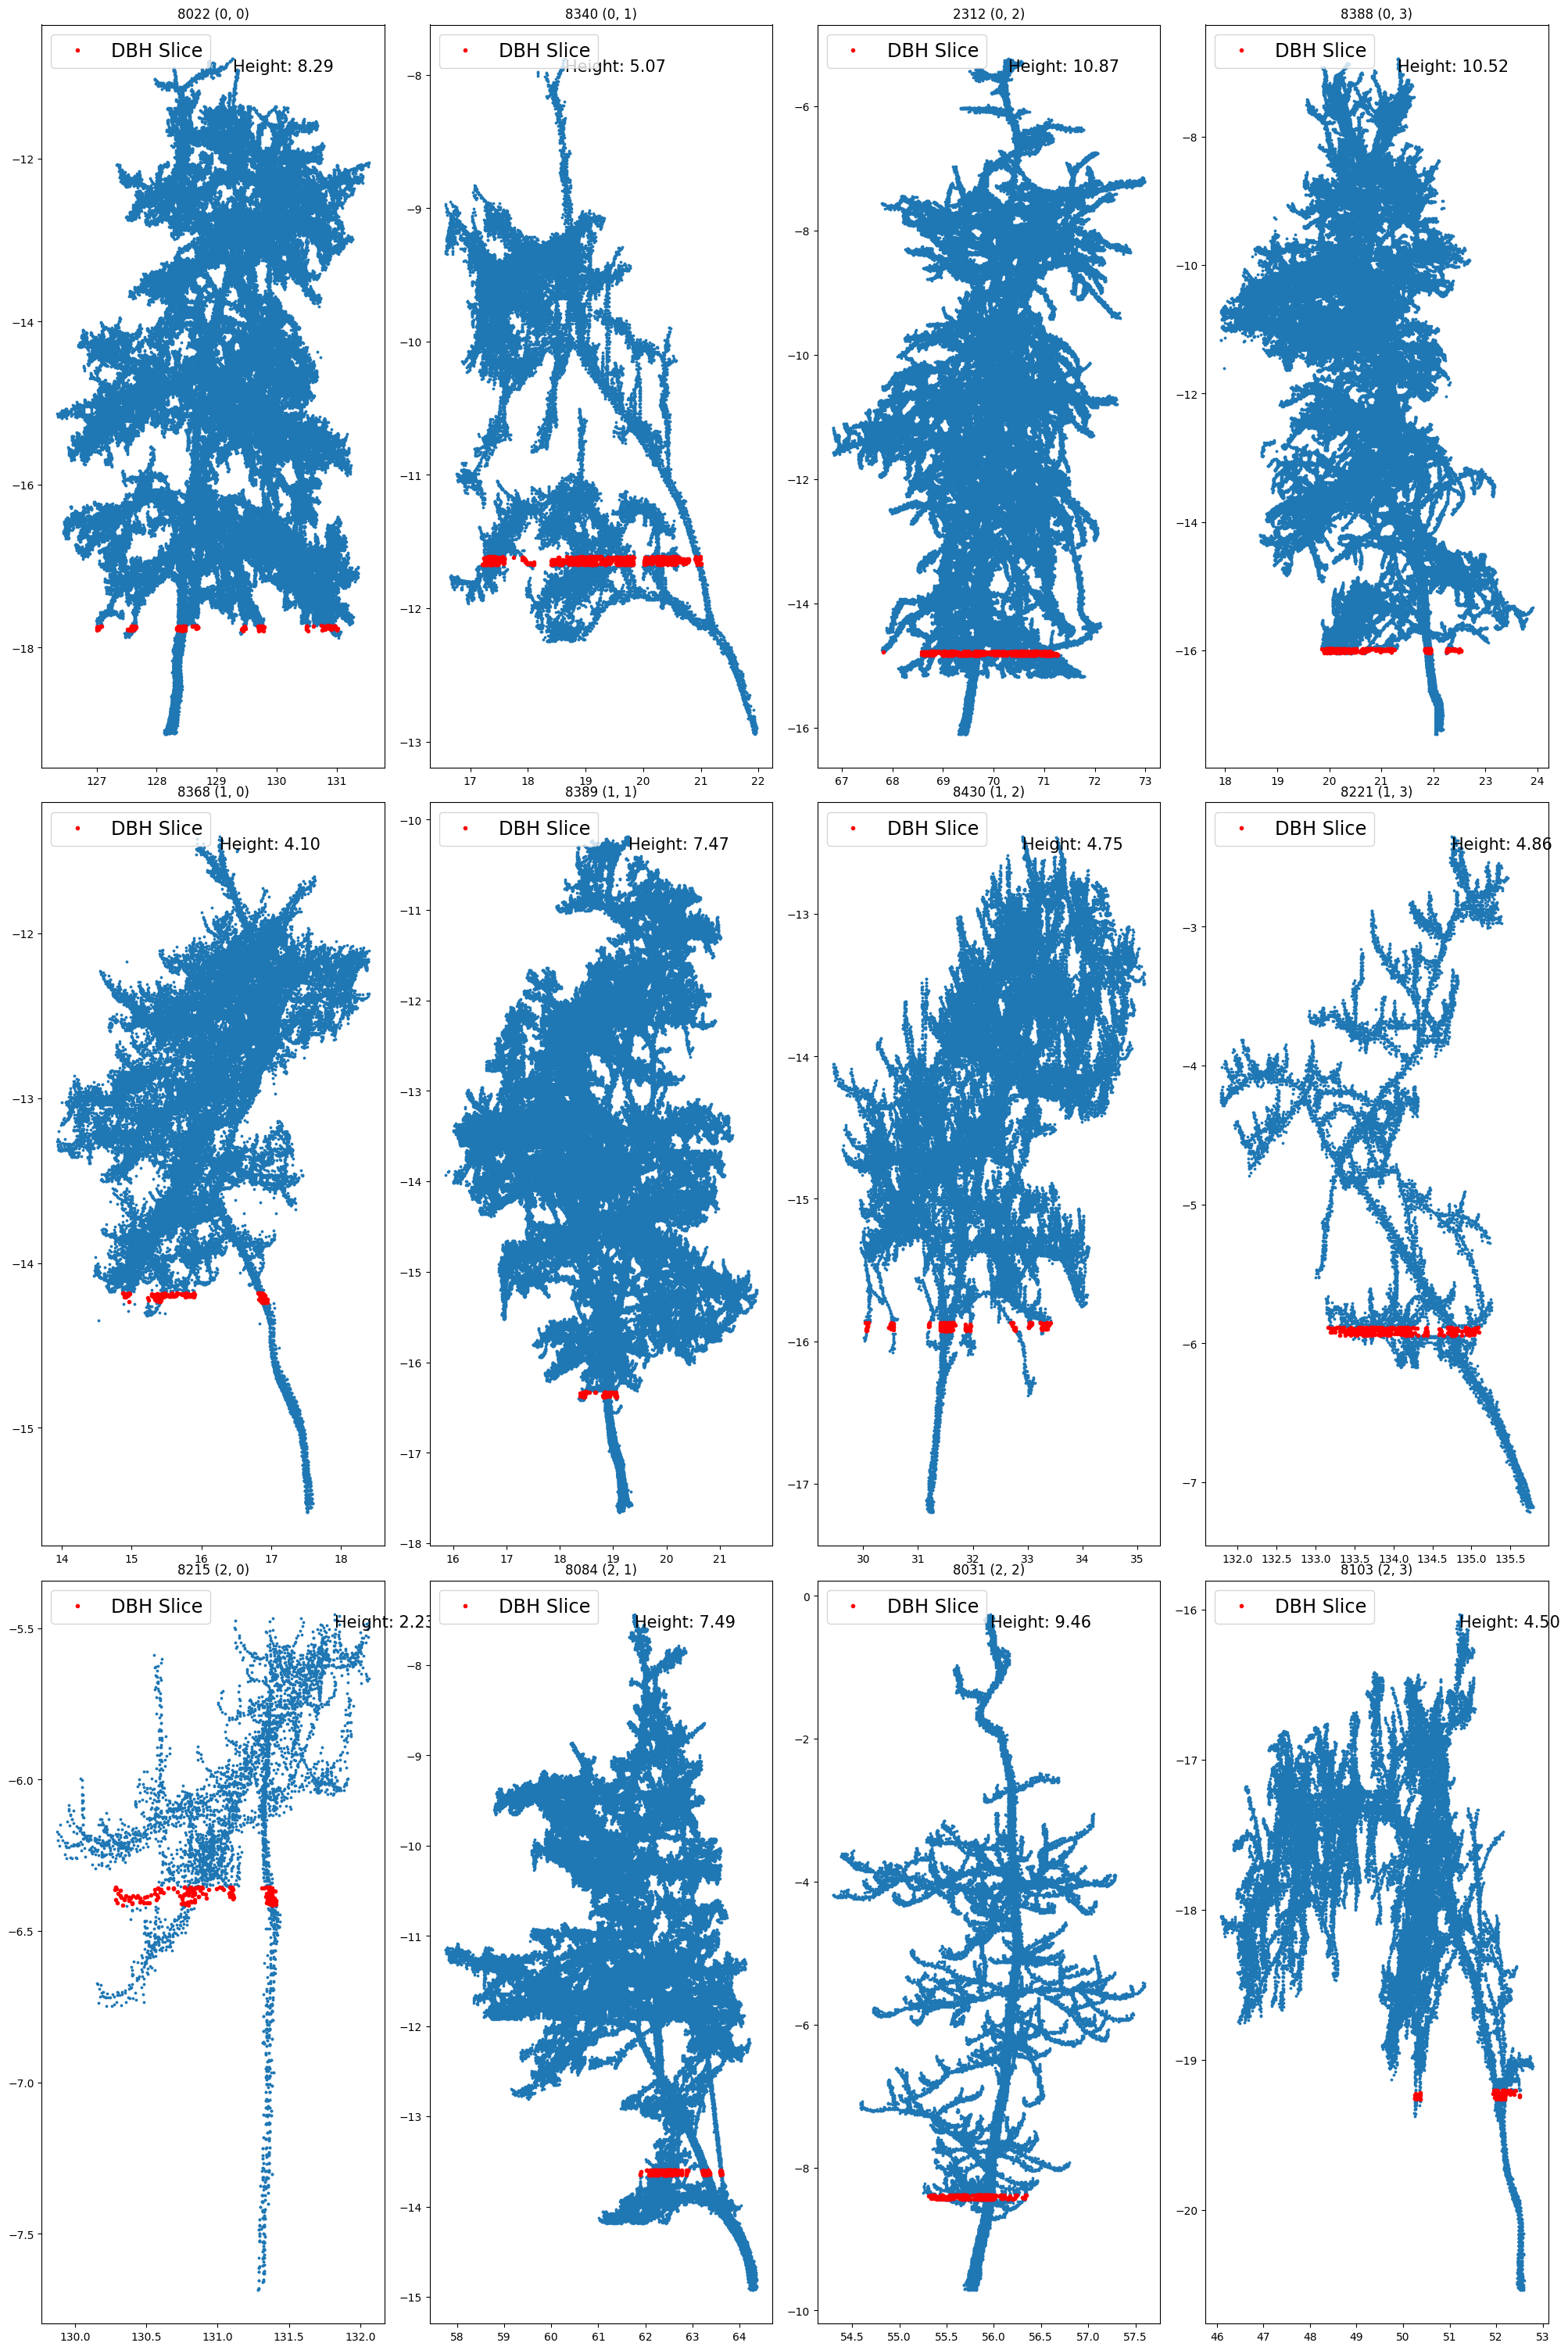

In [19]:
# plot these issue trees in 2d
#trees = ['1596', '8348', '225', '2115', '2063', '2262', '70', '2317']
#print(bigtrees)
plot2D(bigtrees, pts_path, ncols=4)

### Iterative DBH by Slice:

In [20]:
# Create a dictionary with tree ids as keys and values of dataframes of dbh along stem
iterdbh_dict = {}

for tree in singlestemmed:
    tree_num, iterdbhout = iter_dbh(tree, pts_path, step=0.1, lim=3)
    
    iterdbh_dict[tree_num] = iterdbhout

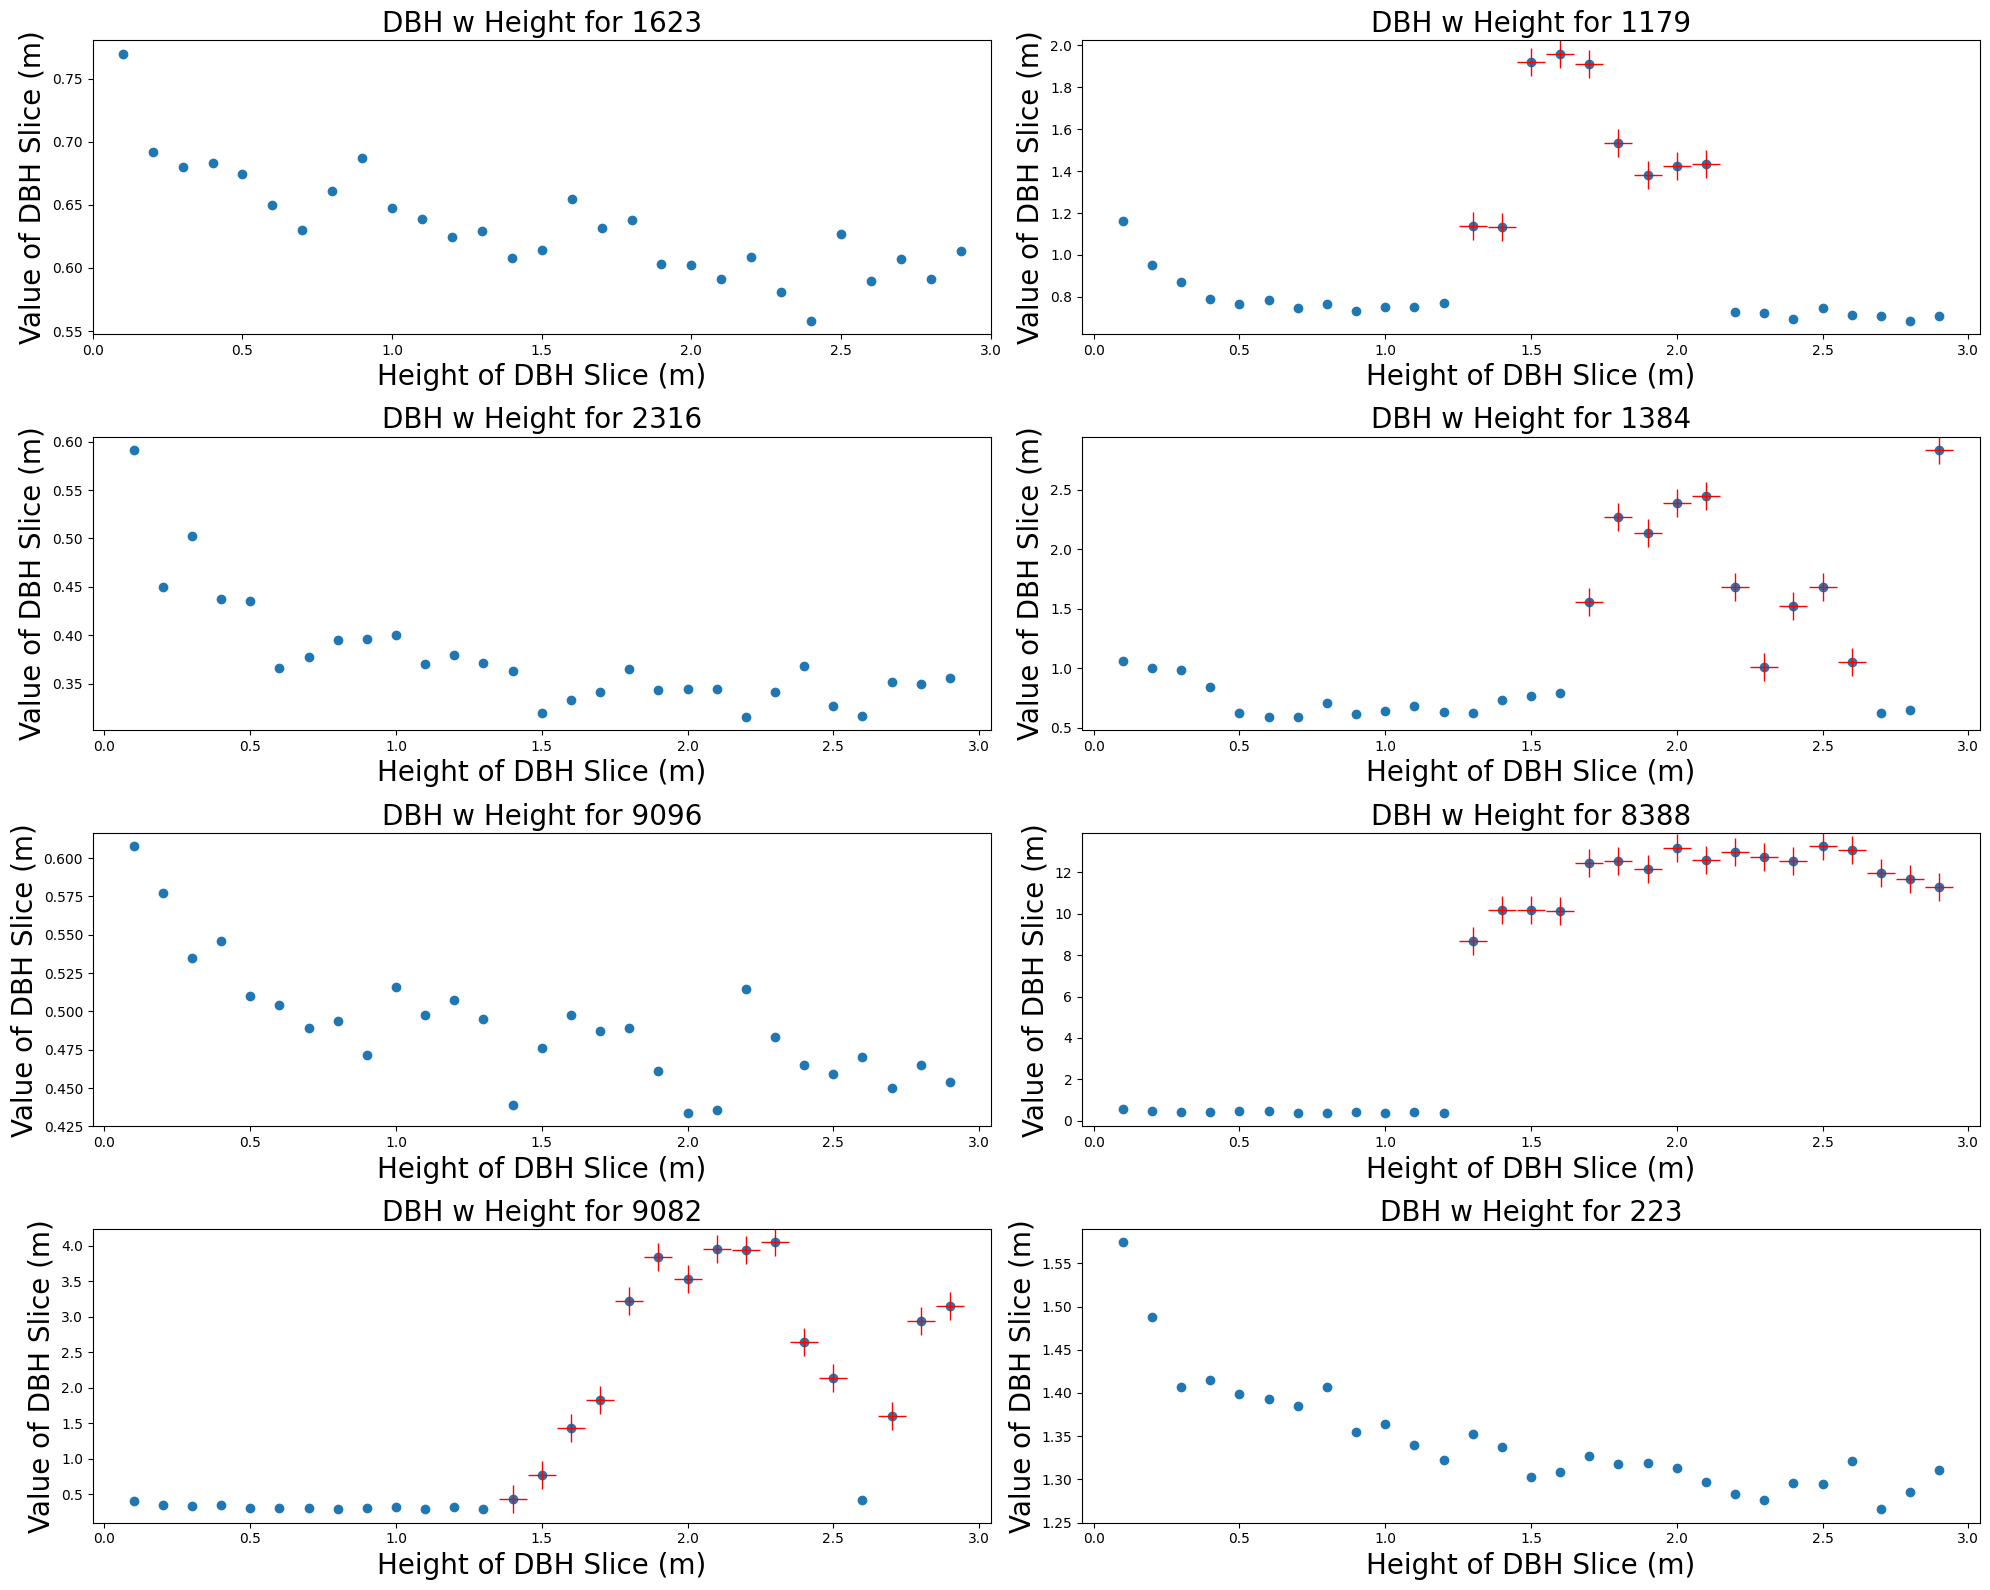

In [26]:
# run for just a few trees to get a dictionary to plot
iterdbh_dict_plot = {}
for tree in singlestemmed[0:8]:
    tree_num, iterdbhout = iter_dbh(tree, pts_path, step=0.1, lim=3)
    
    iterdbh_dict_plot[tree_num] = iterdbhout
    
plot_iter_dbh(iterdbh_dict_plot, ncols = 2)

In [27]:
# get heights at which to record dbhh for full dataset
dbh_hgts = get_dbh_hgt(iterdbh_dict)

tree 1623, res: 1.3
tree 1179, res: 1.2
tree 2316, res: 1.3
tree 1384, res: 1.3
tree 9096, res: 1.3
tree 8388, res: 1.2
tree 9082, res: 1.3
tree 223, res: 1.3
tree 8377, res: 1.3
tree 419, res: 1.3
tree 1596, res: 0.7999999999999999
tree 425, res: 1.3
tree 8203, res: 1.3
tree 9109, res: 1.3
tree 8217, res: 1.4000000000000001
tree 380, res: 1.3
tree 1970, res: 1.3
tree 8015, res: 1.4000000000000001
tree 1757, res: 1.3
tree 1019, res: 1.3
tree 196, res: 1.3
tree 2262, res: 1.3
tree 829, res: 1.3
tree 8014, res: 1.3
tree 154, res: 1.3
tree 8216, res: 1.3
tree 9108, res: 1.2
tree 424, res: 1.3
tree 2115, res: 1.3
tree 8404, res: 1.3
tree 8410, res: 1.3
tree 9083, res: 1.3
tree 222, res: 1.3
tree 236, res: 1.3
tree 8389, res: 0.9999999999999999
tree 1391, res: 1.3
tree 2317, res: 1.3
tree 8174, res: 1.0999999999999999
tree 73, res: 1.3
tree 746, res: 1.3
tree 1811, res: 0.9999999999999999
tree 752, res: 1.3
tree 778, res: 1.3
tree 1191, res: 1.3
tree 1807, res: 1.3
tree 8162, res: 1.3
tree 

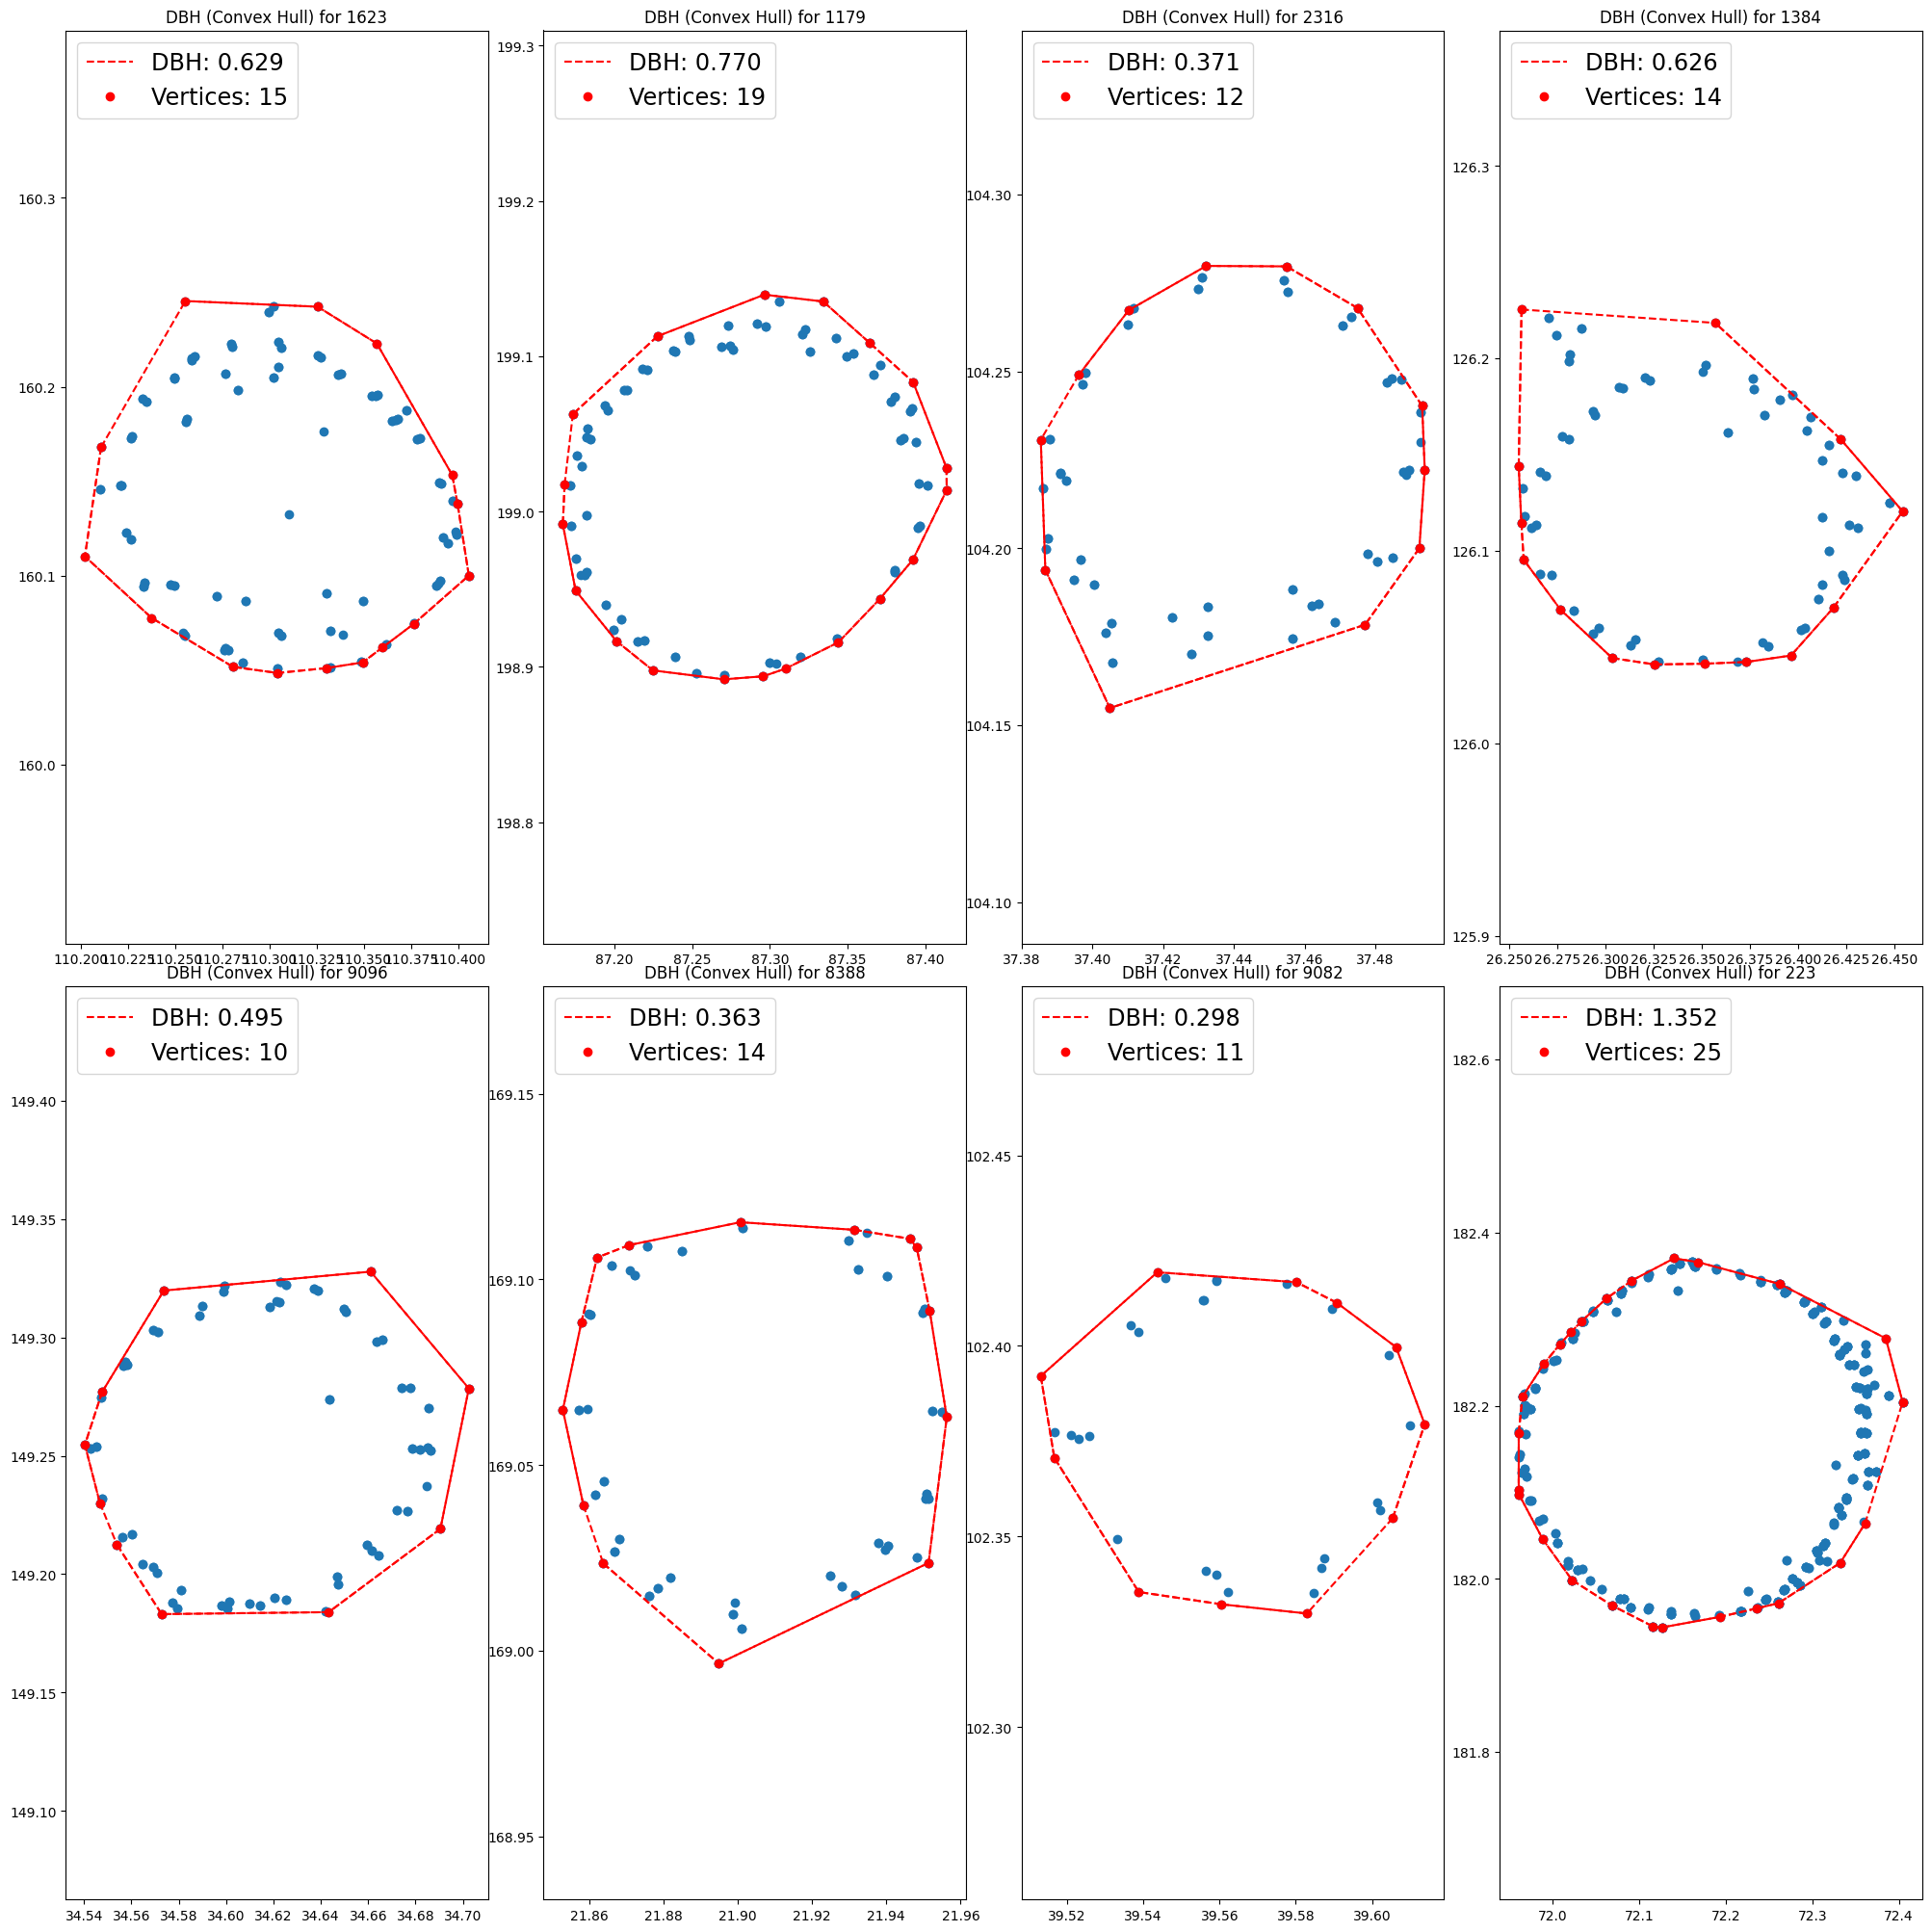

In [28]:
# now calculate dbh at the specified heights to avoid branches
big_datadict = {}

for tree in singlestemmed:
    # construct tree id
    tree, tree_num = construct_treeid(tree, pts_path)
    
    dbh_hgt = dbh_hgts[tree_num]
    
    # calc convex hull
    dbh_cv, verts, pts_dbh, dbh = calc_convexhull(tree, pts_path, hgt=dbh_hgt)
    
    big_datadict[tree_num] = {'dbh_cv': dbh_cv, 'verts': verts}

plot_convexhull(singlestemmed[0:8], pts_path, ncols=4, fixedheight = False, hgtlist = dbh_hgts)  

/Users/snix/.pyenv/versions/3.8.13/lib/python3.8/site-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/snix/.pyenv/versions/3.8.13/lib/python3.8/site-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/Users/snix/.pyenv/versions/3.8.13/lib/python3.8/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/snix/.pyenv/versions/3.8.13/lib/python3.8/site-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

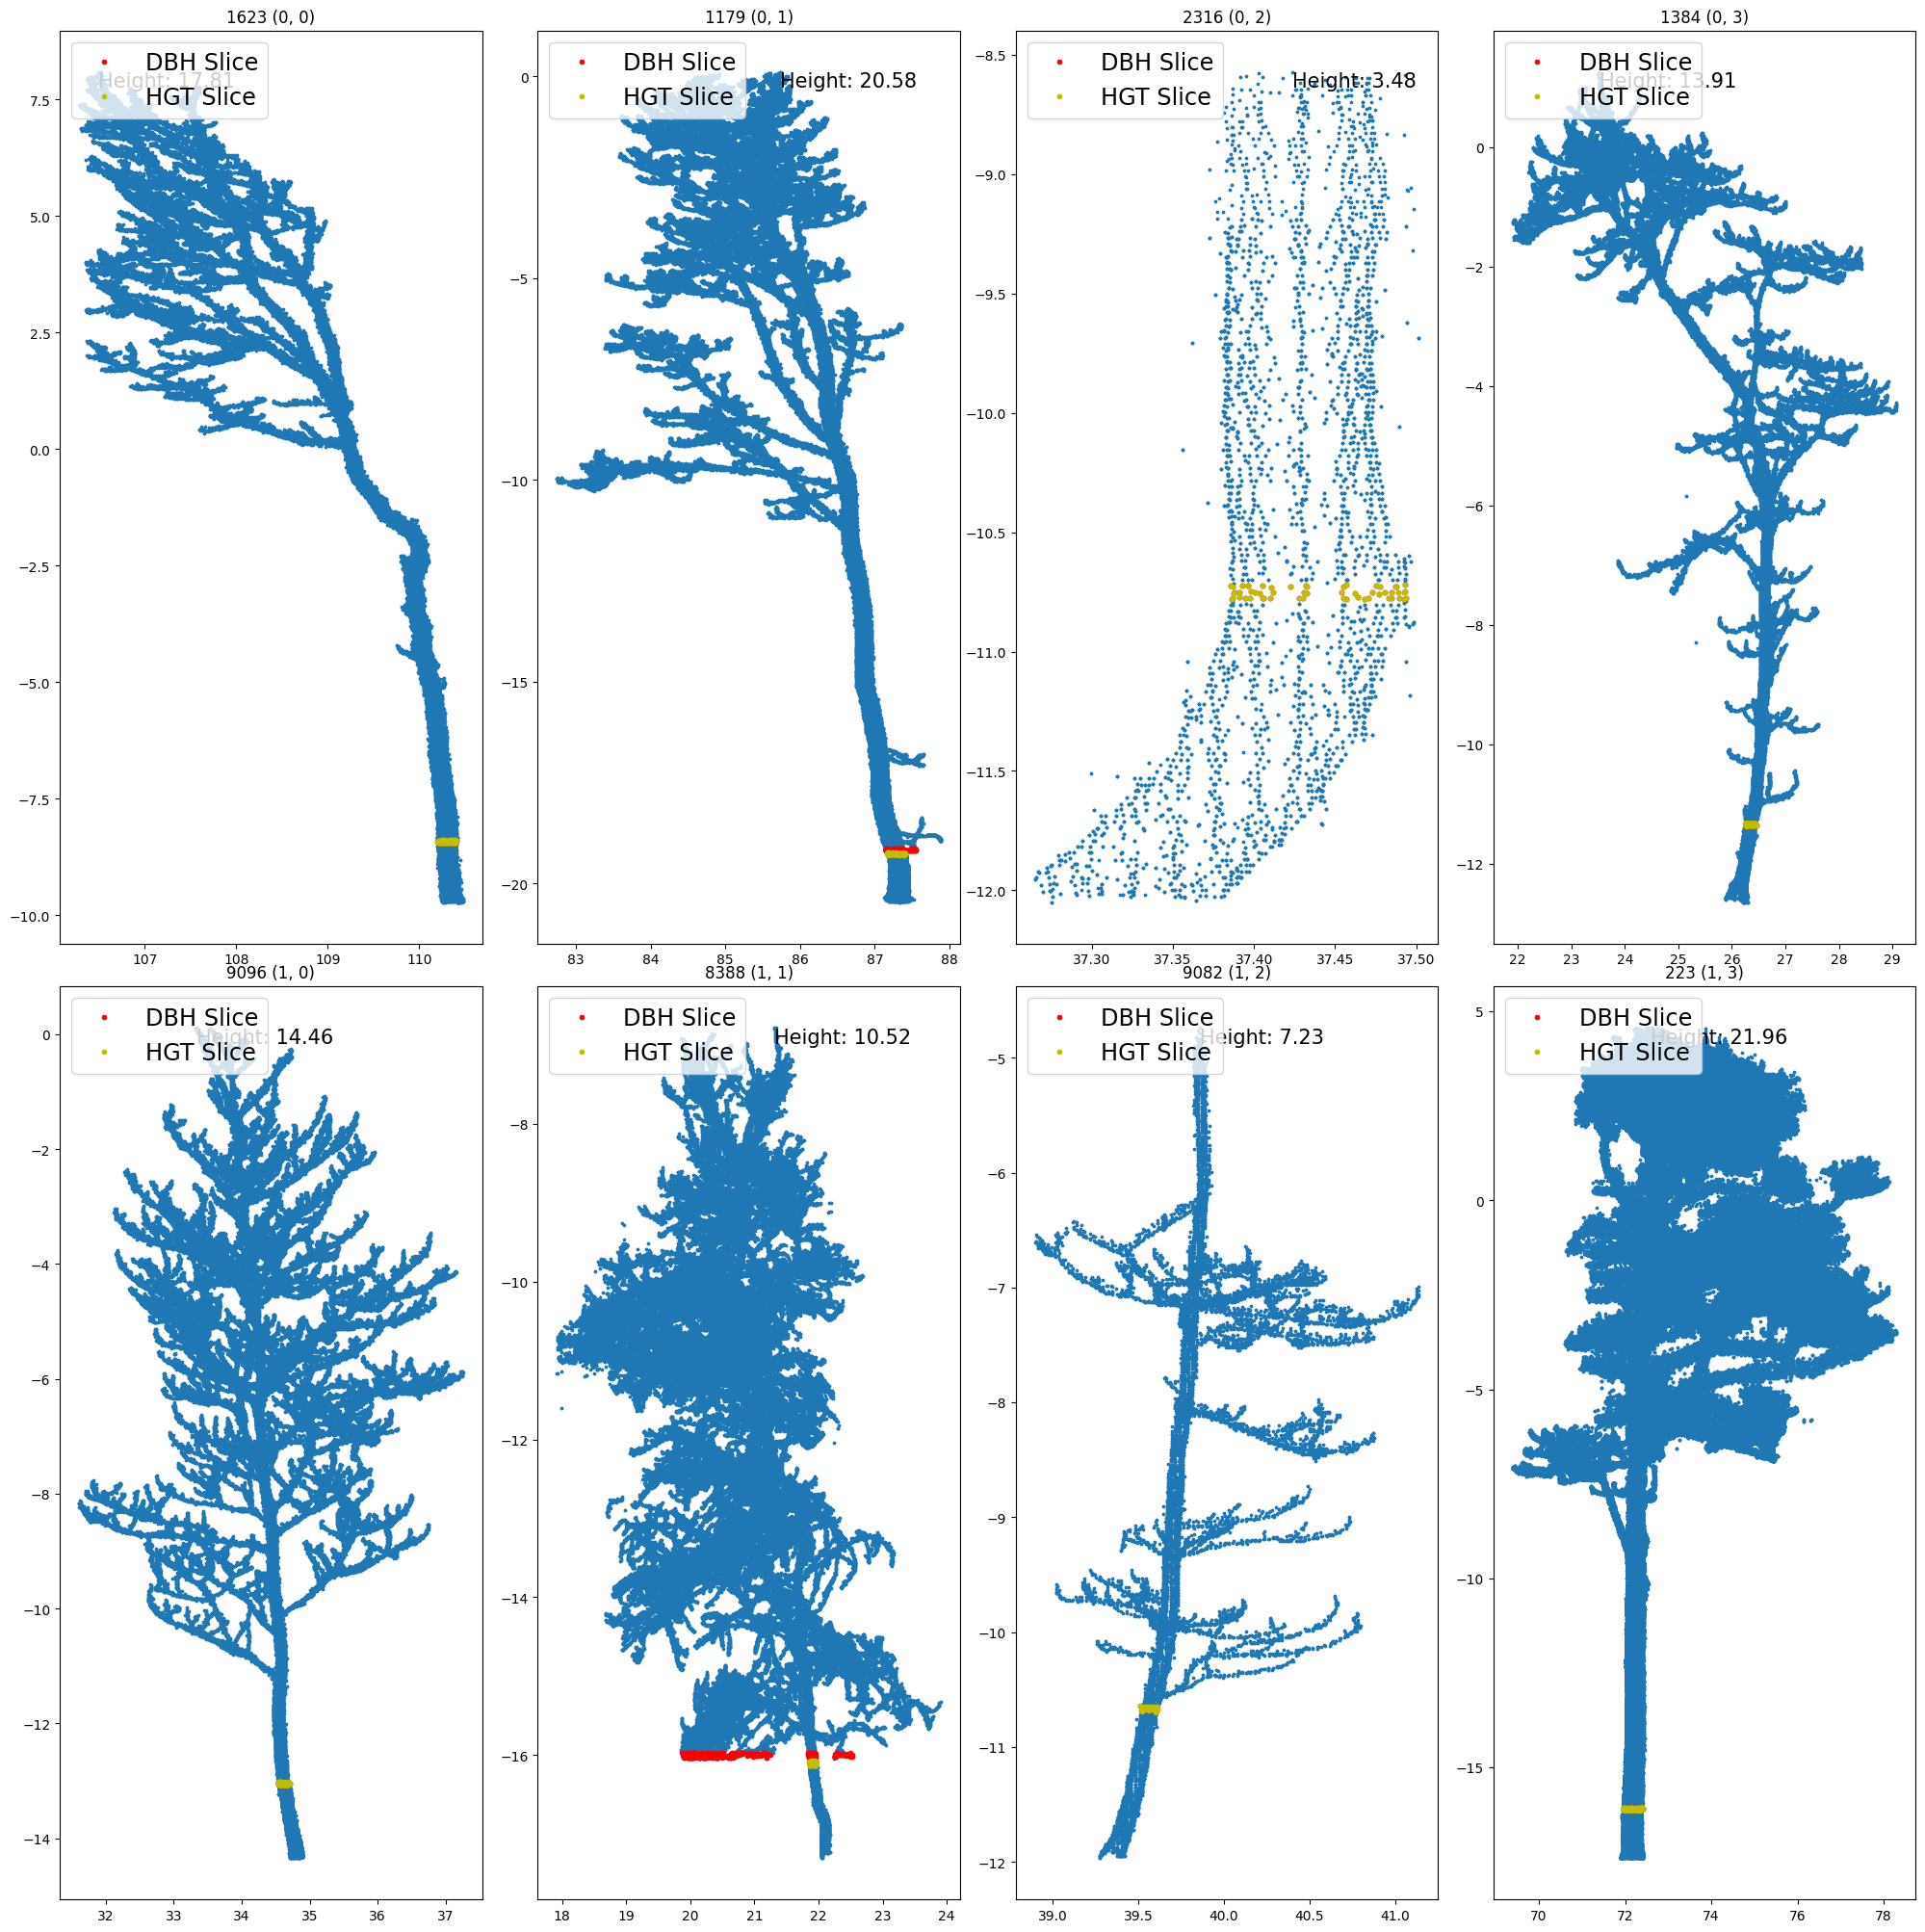

In [29]:
plot2D(singlestemmed[0:8], pts_path, ncols=4, dbh=True, iterdbh=True, hgtlist = dbh_hgts)

In [38]:
#convert full data dictionary into dataframe for analysis and predictions

big_datadf = pd.DataFrame.from_dict(big_datadict, orient='index')


big_datadf = big_datadf.reset_index()
big_datadf = big_datadf.rename(columns={"index": "TLS_ID"})

big_datadf

TLS_ID    dbh_cv  verts
0     1623  0.628945     15
1     1179  0.770253     19
2     2316  0.371395     12
3     1384  0.626443     14
4     9096  0.494922     10
..     ...       ...    ...
580   8150  0.404935     10
581    979  1.093398     18
582   8178  0.872390     14
583   8193  0.508923      8
584   1821  0.534745      9

[585 rows x 3 columns]

# DBH (Convex Hull) Results

### Predict DBH:

In [39]:
treecsv = pd.read_csv(tree_csv_path)


treecsv = treecsv[['TLS_ID','stemlocx_[m]', 'stemlocy_[m]', 'DBH_TLS_[m]',
                    'Hgt_pts_[m]', 'VerticalCrownProjectedArea_pts_[m2]', 'Vol_QSM_avg_[m3]',
                    'Vol_QSM_D0_25mm_avg_[m3]', 'Vol_QSM_D25_50mm_avg_[m3]', 'Vol_QSM_D50_75mm_avg_[m3]',
                    'Vol_QSM_D75_100mm_avg_[m3]', 'Vol_QSM_D100_200mm_avg_[m3]', 'Vol_QSM_D200_500mm_avg_[m3]',
                    'Vol_QSM_D500_1000mm_avg_[m3]', 'Vol_QSM_D1000mm_avg_[m3]']]


treedata = pd.merge(big_datadf, treecsv, on ='TLS_ID')

treedata.head()

TLS_ID    dbh_cv  verts  stemlocx_[m]  stemlocy_[m]  DBH_TLS_[m]  \
0   1623  0.628945     15    110.306410    160.139205     0.166835   
1   1179  0.770253     19     87.160407    198.975028     0.218800   
2   2316  0.371395     12     37.438642    104.223540     0.105306   
3   1384  0.626443     14     26.342215    126.120809     0.166352   
4   9096  0.494922     10     34.613703    149.252665     0.137708   

   Hgt_pts_[m]  VerticalCrownProjectedArea_pts_[m2]  Vol_QSM_avg_[m3]  \
0    17.793612                             7.856278           0.29930   
1    20.527044                            11.785311           0.56040   
2     3.455709                             0.080840           0.02564   
3    13.854225                            24.175029           0.34330   
4    14.451563                            18.630160           0.25590   

   Vol_QSM_D0_25mm_avg_[m3]  Vol_QSM_D25_50mm_avg_[m3]  \
0                  0.012391                   0.046016   
1                  0.025567                   0.108023   
2                  0.000041                   0.000272   
3                  0.025936                   0.090311   
4                  0.041416                   0.099663   

   Vol_QSM_D50_75mm_avg_[m3]  Vol_QSM_D75_100mm_avg_[m3]  \
0                   0.028089                    0.022503   
1                   0.050840                    0.012992   
2                   0.000342                    0.010291   
3                   0.022800                    0.011619   
4                   0.010168                    0.019781   

   Vol_QSM_D100_200mm_avg_[m3]  Vol_QSM_D200_500mm_avg_[m3]  \
0                     0.190420                     0.000000   
1                     0.250562                     0.112448   
2                     0.014683                     0.000000   
3                     0.192744                     0.000000   
4                     0.084797                     0.000000   

   Vol_QSM_D500_1000mm_avg_[m3]  Vol_QSM_D1000mm_avg_[m3]  
0                           0.0                       0.0  
1                           0.0                       0.0  
2                           0.0                       0.0  
3                           0.0                       0.0  
4                           0.0                       0.0

## Compare Convex Hull with "DBH_TLS[m]"

Text(0, 0.5, 'DBH from TLS')

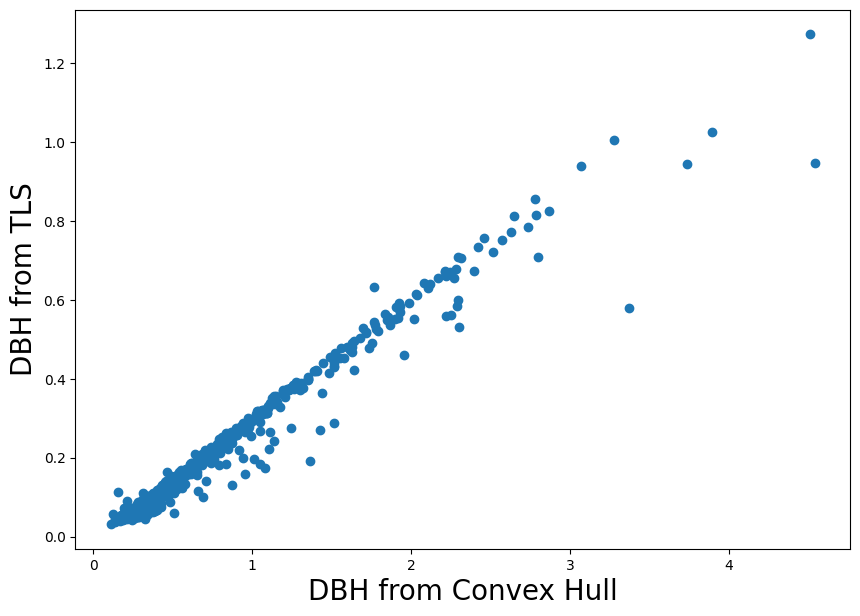

In [42]:
# select only single stem trees from csv 
#ss_treedata = treecsv[treecsv[['TLS_ID']].apply(lambda x: x[-1].isdigit(), axis=1)]

#smalltrees = treedata[treedata['DBH_CV']<4]

plt.figure(figsize=(10,7))
plt.scatter(treedata['dbh_cv'], treedata['DBH_TLS_[m]'])
plt.xlabel('DBH from Convex Hull', fontsize=20)
plt.ylabel('DBH from TLS', fontsize=20)


## Random Forest (Predicting DBH from QSMs)

In [50]:
#https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# Labels are the values we want to predict
labels = np.array(treedata['dbh_cv'])

# Remove the labels from the features
# axis 1 refers to the columns
features = treedata.drop(['TLS_ID','dbh_cv', 'DBH_TLS_[m]'], axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [51]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)



In [52]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (417, 14)
Training Labels Shape: (417,)
Testing Features Shape: (140, 14)
Testing Labels Shape: (140,)


In [53]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [54]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')



Mean Absolute Error: 0.1
Accuracy: 88.66 %.


In [55]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Vol_QSM_avg_[m3]     Importance: 0.43
Variable: Vol_QSM_D200_500mm_avg_[m3] Importance: 0.31
Variable: Vol_QSM_D500_1000mm_avg_[m3] Importance: 0.16
Variable: Vol_QSM_D100_200mm_avg_[m3] Importance: 0.03
Variable: Vol_QSM_D1000mm_avg_[m3] Importance: 0.03
Variable: verts                Importance: 0.01
Variable: stemlocx_[m]         Importance: 0.01
Variable: VerticalCrownProjectedArea_pts_[m2] Importance: 0.01
Variable: Vol_QSM_D50_75mm_avg_[m3] Importance: 0.01
Variable: stemlocy_[m]         Importance: 0.0
Variable: Hgt_pts_[m]          Importance: 0.0
Variable: Vol_QSM_D0_25mm_avg_[m3] Importance: 0.0
Variable: Vol_QSM_D25_50mm_avg_[m3] Importance: 0.0
Variable: Vol_QSM_D75_100mm_avg_[m3] Importance: 0.0


In [56]:
#rf_results = pd.DataFrame(mape, predictions, test_labels)

rf_results = pd.DataFrame({'mape': mape, 'errors': errors,'predictions': predictions, 'test_labels': test_labels}, columns=['mape', 'errors', 'predictions', 'test_labels'])

plt.figure(figsize=(10,7))
plt.scatter(rf_results['predictions'], rf_results['test_labels'])
plt.xlabel('Predictions (DBH)', fontsize=20)
plt.ylabel('Measured Values (DBH)', fontsize=20)


Text(0, 0.5, 'Measured Values (DBH)')

Text(0, 0.5, 'Errors')

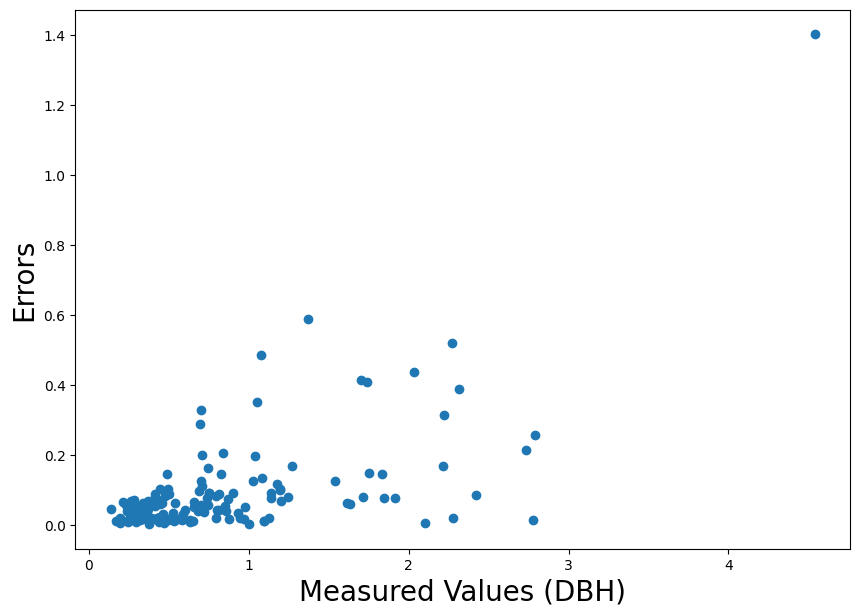

In [57]:
plt.figure(figsize=(10,7))
plt.scatter(rf_results['test_labels'], rf_results['errors'])
plt.xlabel('Measured Values (DBH)', fontsize=20)
plt.ylabel('Errors', fontsize=20)

In [58]:
# merge rf results back with original dataset
#https://stackoverflow.com/questions/40729162/merging-results-from-model-predict-with-original-pandas-dataframe
# TODO: in final - re-run model on full dataset and split into training vs testing

df_out = pd.merge(treedata,rf_results[['mape', 'errors', 'predictions']],how = 'left',left_index = True, right_index = True)

#rf_results.shape
df_out.head(150)

TLS_ID    dbh_cv  verts  stemlocx_[m]  stemlocy_[m]  DBH_TLS_[m]  \
0     1623  0.628945     15    110.306410    160.139205     0.166835   
1     1179  0.770253     19     87.160407    198.975028     0.218800   
2     2316  0.371395     12     37.438642    104.223540     0.105306   
3     1384  0.626443     14     26.342215    126.120809     0.166352   
4     9096  0.494922     10     34.613703    149.252665     0.137708   
..     ...       ...    ...           ...           ...          ...   
145    541  1.139307     36     13.495170    122.425158     0.356943   
146    555  0.901050     19     17.733364    135.575942     0.274058   
147   8165  0.352572      9    109.179394    145.557727     0.073190   
148     62  2.032409     31      4.564764    161.138665     0.616253   
149   8171  0.246743      9    103.085338    152.756905     0.063654   

     Hgt_pts_[m]  VerticalCrownProjectedArea_pts_[m2]  Vol_QSM_avg_[m3]  \
0      17.793612                             7.856278           0.29930   
1      20.527044                            11.785311           0.56040   
2       3.455709                             0.080840           0.02564   
3      13.854225                            24.175029           0.34330   
4      14.451563                            18.630160           0.25590   
..           ...                                  ...               ...   
145    19.547412                            47.502726           2.04870   
146    21.226756                            24.695598           1.24560   
147     9.777196                             8.903448           0.05483   
148    20.944305                           109.674080           5.68480   
149     8.340966                             0.075362           0.01791   

     Vol_QSM_D0_25mm_avg_[m3]  Vol_QSM_D25_50mm_avg_[m3]  \
0                    0.012391                   0.046016   
1                    0.025567                   0.108023   
2                    0.000041                   0.000272   
3                    0.025936                   0.090311   
4                    0.041416                   0.099663   
..                        ...                        ...   
145                  0.071407                   0.356241   
146                  0.035671                   0.188407   
147                  0.007039                   0.030383   
148                  0.159283                   0.706220   
149                  0.000294                   0.003357   

     Vol_QSM_D50_75mm_avg_[m3]  Vol_QSM_D75_100mm_avg_[m3]  \
0                     0.028089                    0.022503   
1                     0.050840                    0.012992   
2                     0.000342                    0.010291   
3                     0.022800                    0.011619   
4                     0.010168                    0.019781   
..                         ...                         ...   
145                   0.312827                    0.155776   
146                   0.164069                    0.108160   
147                   0.014448                    0.002956   
148                   0.797275                    0.635281   
149                   0.009348                    0.004924   

     Vol_QSM_D100_200mm_avg_[m3]  Vol_QSM_D200_500mm_avg_[m3]  \
0                       0.190420                     0.000000   
1                       0.250562                     0.112448   
2                       0.014683                     0.000000   
3                       0.192744                     0.000000   
4                       0.084797                     0.000000   
..                           ...                          ...   
145                     0.263548                     0.888918   
146                     0.276888                     0.472312   
147                     0.000000                     0.000000   
148                     0.858958                     1.174097   
149                     0.000000                     0.00

Text(0, 0.5, 'Errors')

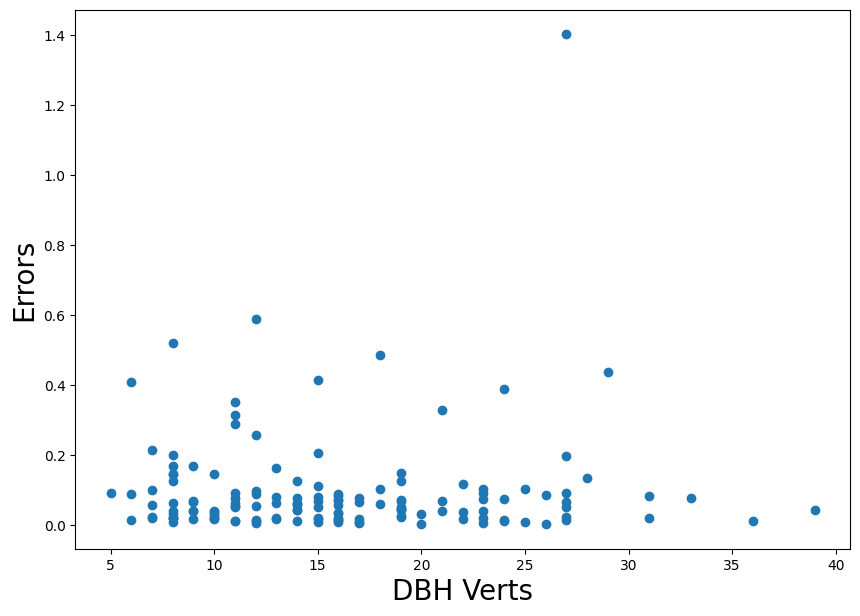

In [60]:
plt.figure(figsize=(10,7))
plt.scatter(df_out['verts'], df_out['errors'])
plt.xlabel('DBH Verts', fontsize=20)
plt.ylabel('Errors', fontsize=20)

# Old Code: 